In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
games = pd.read_csv('../data/games.csv')
games_details = pd.read_csv('../data/games_details.csv', low_memory=False)
players = pd.read_csv('../data/players.csv')
teams = pd.read_csv('../data/teams.csv')
ranking = pd.read_csv('../data/ranking.csv')

TOP 10 PLAYERS WITH MOST GAMES PLAYED

In [13]:
def plot_top(df, column, label_col=None, max_plot=5):
    top_df = df.sort_values(column, ascending=False).head(max_plot)
    
    height = top_df[column]
    x = top_df.index if label_col == None else top_df[label_col]
    
    gold, silver, bronze, other = ('#FFA400', '#bdc3c7', '#cd7f32', '#3498db')
    colors = [gold if i == 0 else silver if i == 1 else bronze if i == 2 else other for i in range(0, len(top_df))]
    
    fig, ax = plt.subplots(figsize=(18, 7))
    ax.bar(x, height, color=colors)
    plt.xticks(x, x, rotation=60)
    plt.xlabel(label_col)
    plt.ylabel(column)
    plt.title(f'Top {max_plot} {column}')
    plt.show()

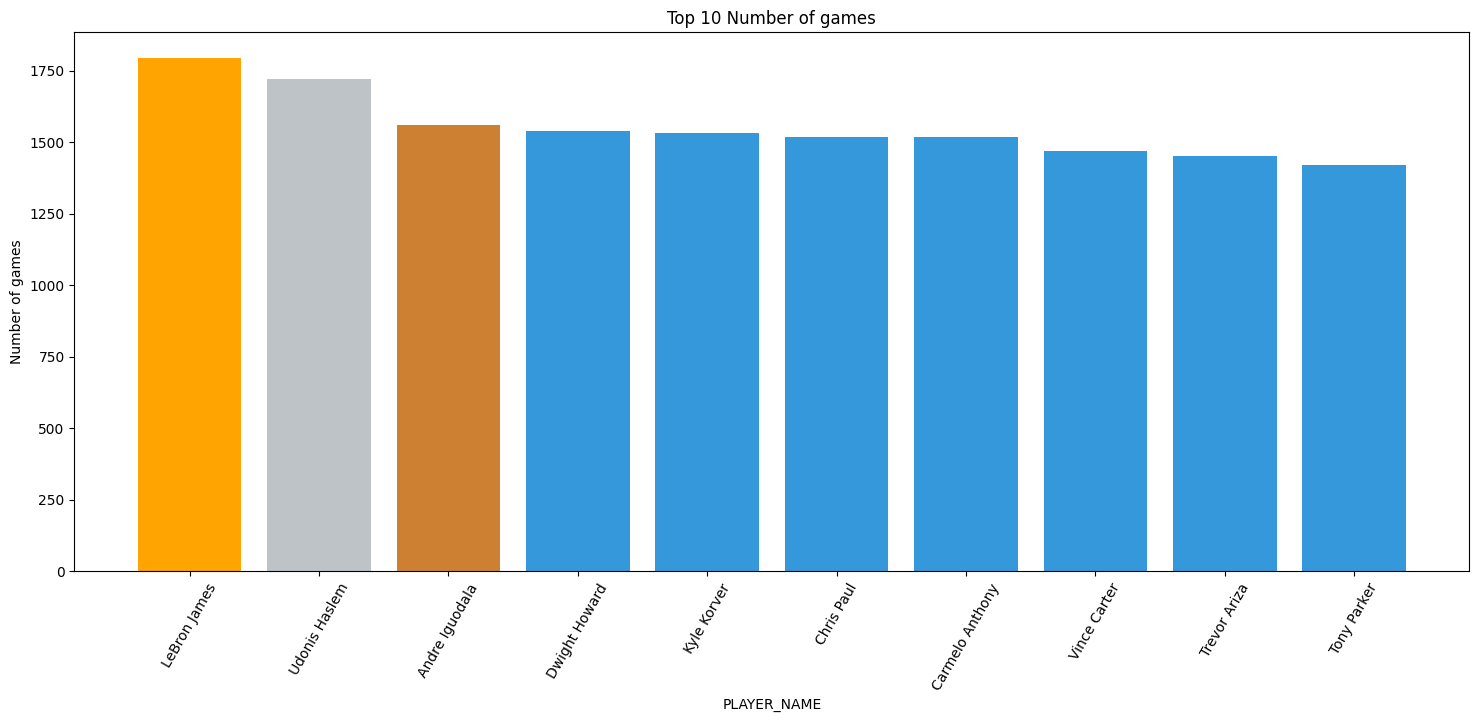

In [14]:
players_name = games_details['PLAYER_NAME']
val_cnt = players_name.value_counts().to_frame().reset_index()
val_cnt.columns = ['PLAYER_NAME', 'Number of games']
plot_top(val_cnt, column='Number of games', label_col='PLAYER_NAME', max_plot=10)

IS MOST GAMES PLAYED MEANS MOST TIME PLAYED?

In [15]:
def convert_min(x):
    if pd.isna(x):
        return 0
    
    x_str = str(x).strip()
    
    try:
        if ':' not in x_str:
            minutes = float(x_str)
            return int(minutes * 60)
        
        parts = x_str.split(':')
        if len(parts) == 1:
            return int(float(parts[0]))
        elif len(parts) == 2:
            minutes = int(float(parts[0]))
            seconds = int(float(parts[1]))
            return minutes * 60 + seconds
        else:
            return 0  
    except ValueError:
        print(f"Failed to convert: {x_str}")
        return 0

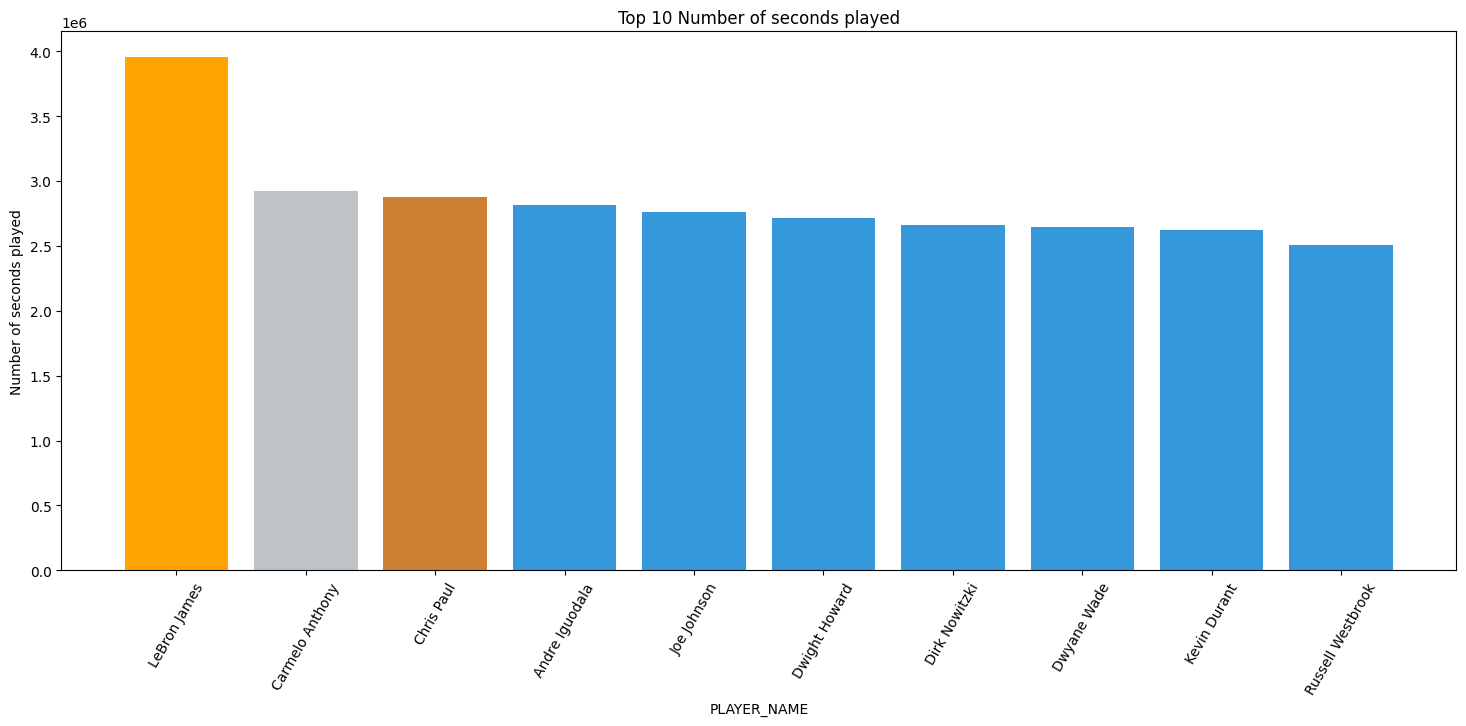

In [16]:
df_tmp = games_details[['PLAYER_NAME', 'MIN']]
df_tmp.loc[:,'MIN'] = df_tmp['MIN'].apply(convert_min)
agg = df_tmp.groupby('PLAYER_NAME').agg('sum').reset_index()
agg.columns = ['PLAYER_NAME', 'Number of seconds played']
plot_top(agg, column='Number of seconds played', label_col='PLAYER_NAME', max_plot=10)

WHICH TEAM HAS THE MOST WINNING SINCE 2004 SEASON?

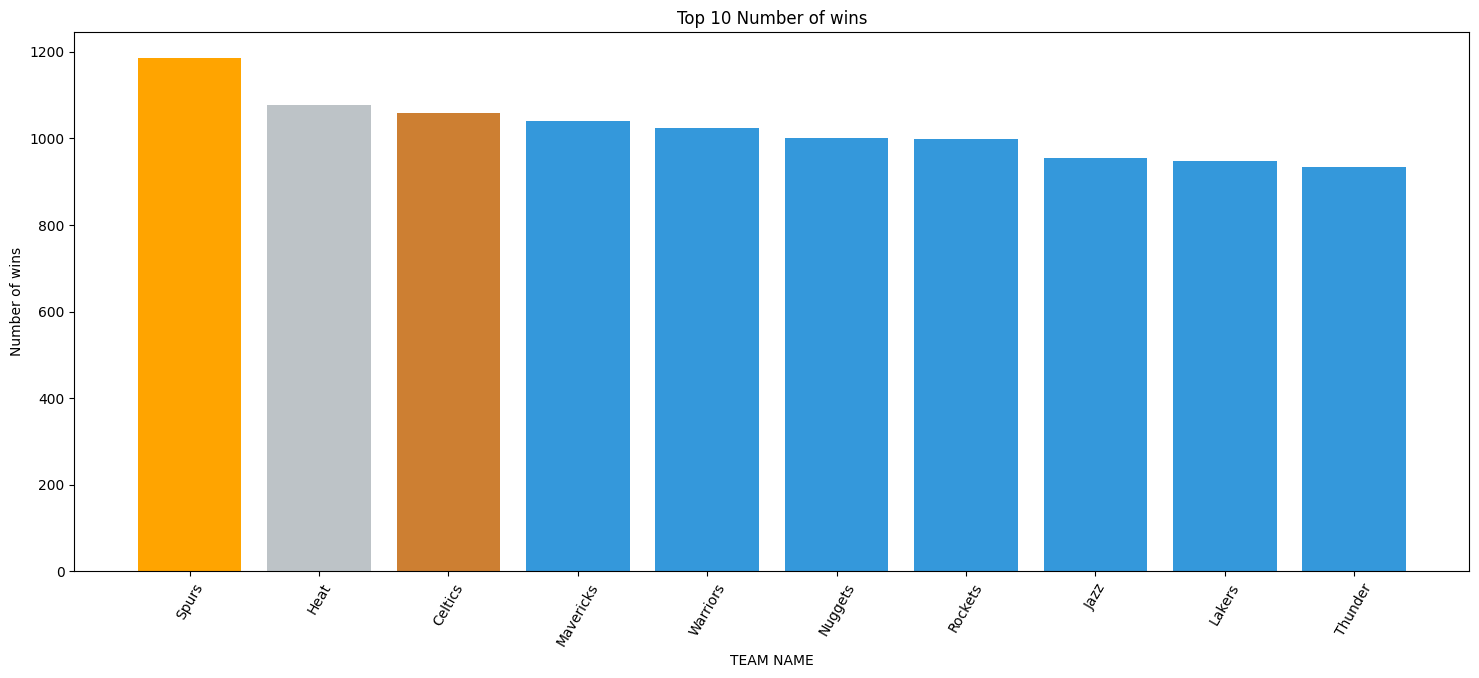

In [17]:
winning_teams = np.where(games['HOME_TEAM_WINS'] == 1, games['HOME_TEAM_ID'], games['VISITOR_TEAM_ID'])
winning_teams = pd.DataFrame(winning_teams, columns=['TEAM_ID'])
winning_teams = winning_teams.merge(teams[['TEAM_ID', 'NICKNAME']], on='TEAM_ID')['NICKNAME'].value_counts().to_frame().reset_index()
winning_teams.columns = ['TEAM NAME', 'Number of wins']
plot_top(winning_teams, column='Number of wins', label_col='TEAM NAME', max_plot=10)

TOP 10 PLAYERS WHO SCORED MOST POINTS

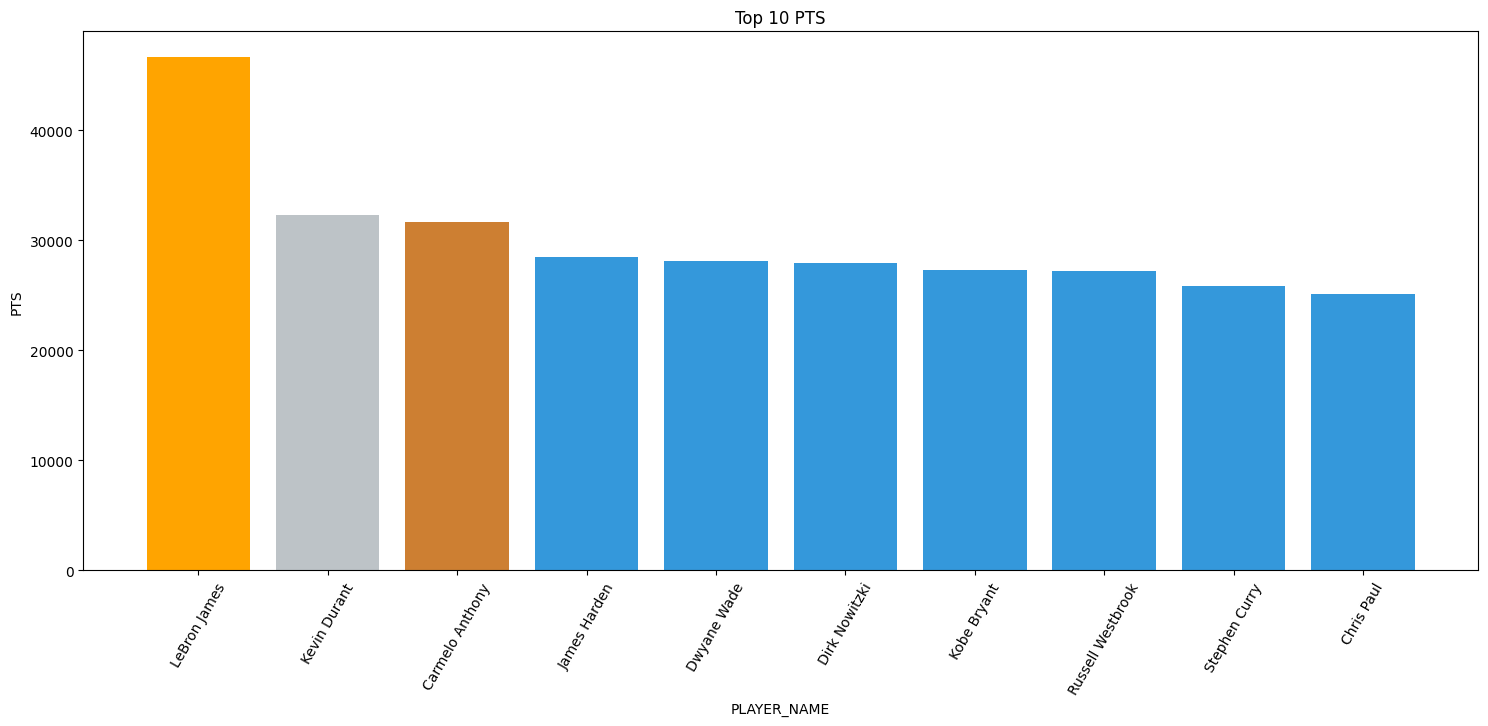

In [18]:
points_by_player = games_details.groupby('PLAYER_NAME')['PTS'].sum().reset_index()
points_by_player = points_by_player.sort_values('PTS', ascending=False)
plot_top(points_by_player, column='PTS', label_col='PLAYER_NAME', max_plot=10)

TOP 10 PLAYERS WHO HAS BEST 3 POINT PERCENTAGE

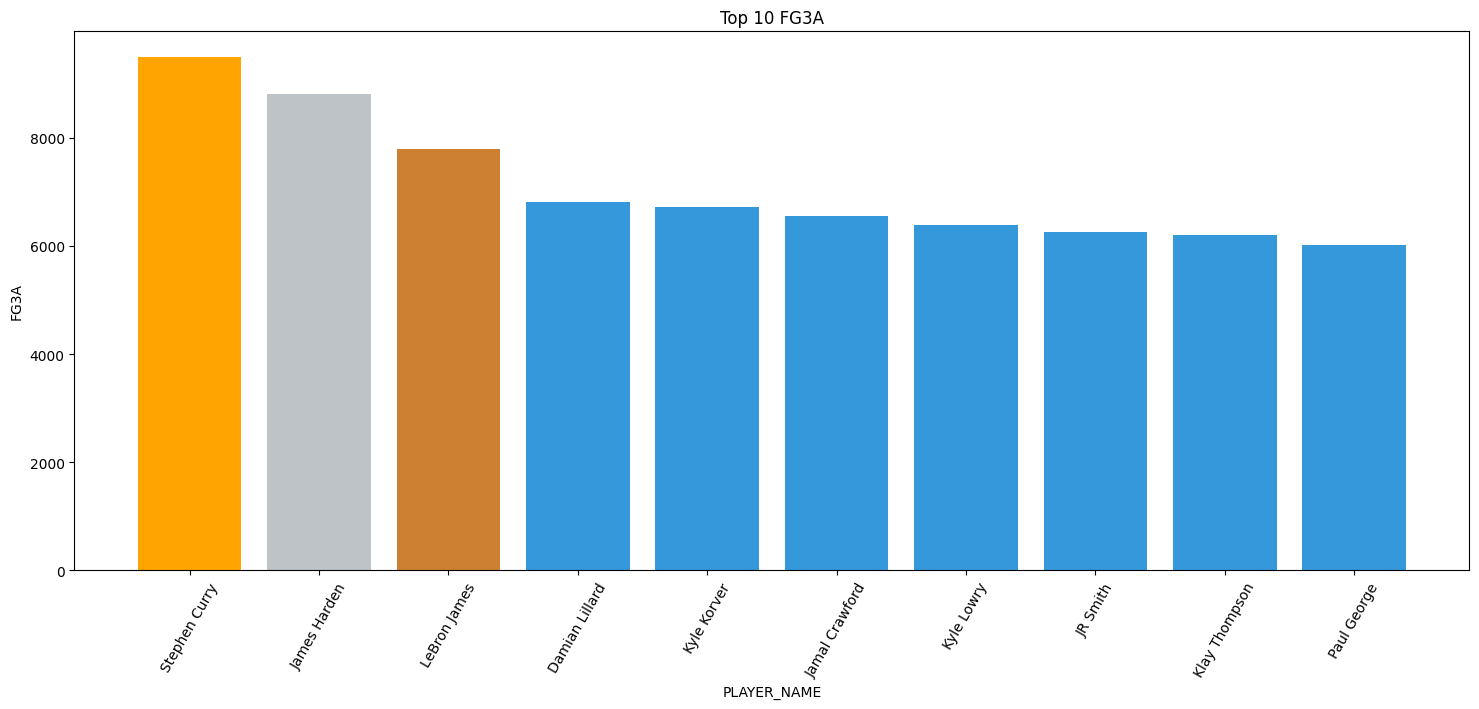

In [19]:
points_by_player3 = games_details.groupby('PLAYER_NAME')['FG3A'].sum().reset_index()
points_by_player3 = points_by_player3.sort_values('FG3A', ascending=False)
plot_top(points_by_player3, column='FG3A', label_col='PLAYER_NAME', max_plot=10)

SEASON GAMES / 2011-2012 lockout

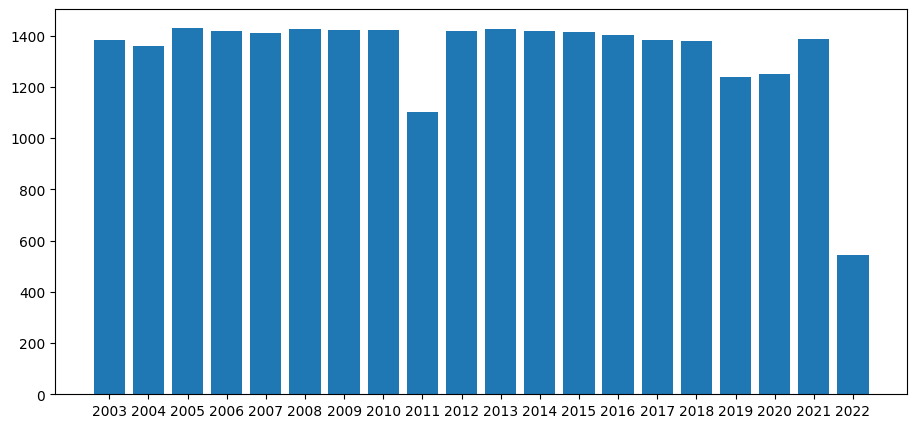

In [20]:
fig, ax = plt.subplots(figsize=(11,5))

values = games['SEASON'].value_counts().sort_index()
values.index = values.index.astype(str)
ax.bar(values.index, values.values)

plt.show()

XGBOOST VISUALIZATIONS

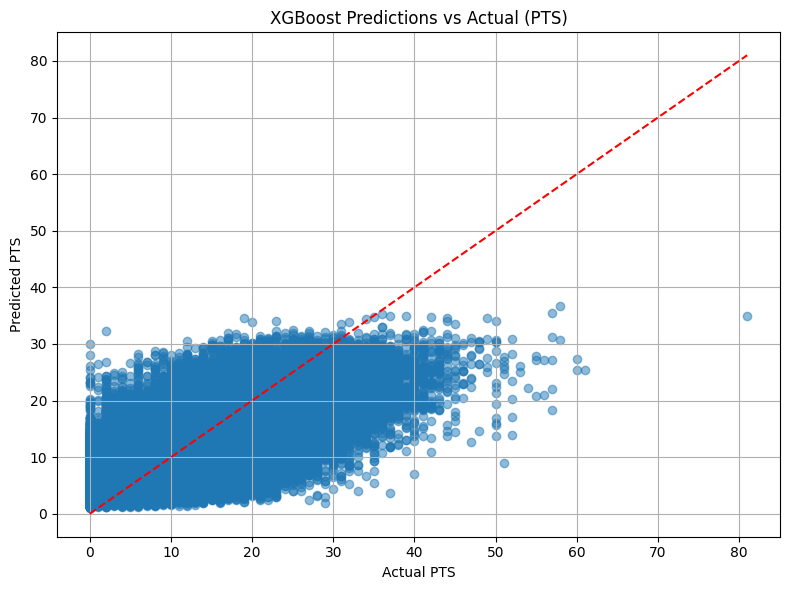

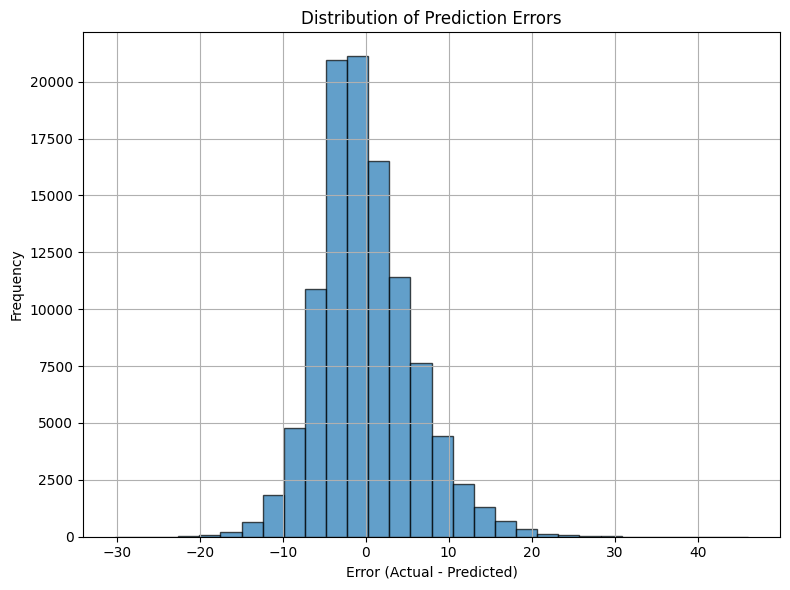

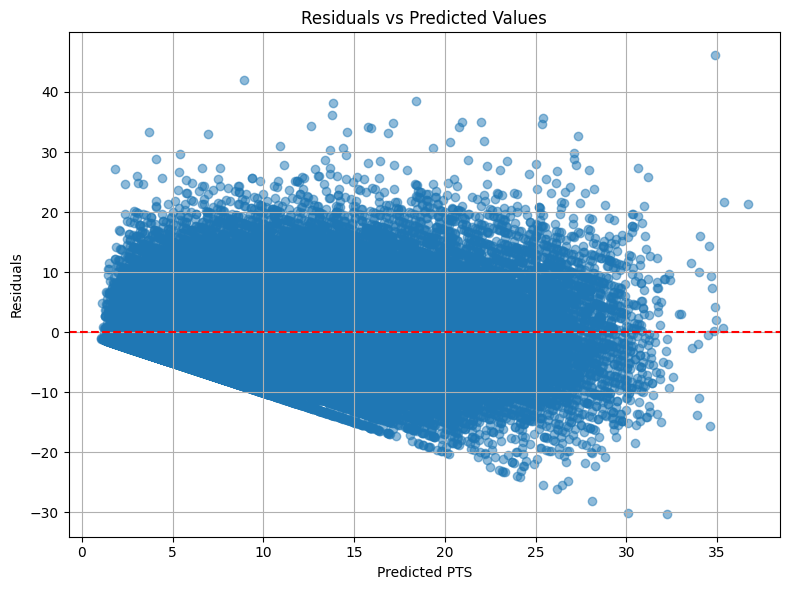


📊 Model Evaluation Metrics:
MAE: 4.3960
MSE: 32.5545
R² Score: 0.5063


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_val = np.load('y_val_xgb.npy')
y_pred = np.load('y_pred_xgb.npy')

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual PTS")
plt.ylabel("Predicted PTS")
plt.title("XGBoost Predictions vs Actual (PTS)")
plt.grid(True)
plt.tight_layout()
plt.show()

errors = y_val - y_pred
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, errors, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted PTS")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"\n📊 Model Evaluation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

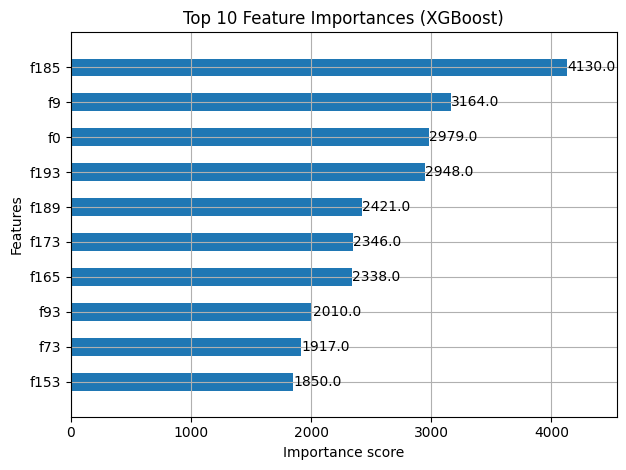

f185 → MIN_t-1
f9 → PTS_AVG_5_t-10
f0 → PTS_t-10
f193 → USAGE_RATE_t-1
f189 → PTS_AVG_5_t-1
f173 → USAGE_RATE_t-2
f165 → MIN_t-2
f93 → USAGE_RATE_t-6
f73 → USAGE_RATE_t-7
f153 → USAGE_RATE_t-3


In [2]:
import joblib

sequence_length = 10
feature_columns = [
    'PTS', 'REB', 'AST', 'STL', 'BLK', 'MIN',
    'FG_PCT', 'FT_PCT', 'FG3_PCT',
    'PTS_AVG_5', 'REB_AVG_5', 'AST_AVG_5',
    'TS_PCT', 'USAGE_RATE', 'PER',
    'DAYS_REST', 'B2B', 'GAMES_LAST_7D',
    'SEASON_GAME_NUM', 'IS_HOME'
]

flattened_feature_names = []
for t in range(sequence_length):
    for feat in feature_columns:
        flattened_feature_names.append(f"{feat}_t-{sequence_length - t}")

final_model = joblib.load("../results/xgboost_tuned_model.pkl")
final_model.feature_names = flattened_feature_names

plot_importance(final_model, max_num_features=10, height=0.5)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

top_features = ['f185', 'f9', 'f0', 'f193', 'f189', 'f173', 'f165', 'f93', 'f73', 'f153']
top_indices = [int(f[1:]) for f in top_features]
for f_idx in top_indices:
    print(f"f{f_idx} → {flattened_feature_names[f_idx]}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Baseline MAE: 6.7851
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
PTS: MAE ↑ -0.0088
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
REB: MAE ↑ 0.0020
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
AST: MAE ↑ 0.0001
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
STL: MAE ↑ -0.0004
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
BLK: MAE ↑ 0.0002
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MIN: MAE ↑ 0.0047
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
FG_PCT: MAE ↑ 0.0005
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
FT_PCT: MAE ↑ -0.0001
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
FG3_PCT: MAE ↑ 0.0001
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
PTS_AVG_5: MAE ↑ 0.0012
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
REB_AVG_5: MAE ↑ -0.0004
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
AST_AVG_5: MAE ↑ 0.0019
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
TS_PCT: MAE ↑ 0.0007
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
USAGE_RATE: MAE ↑ 0.0131
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
PER: MAE ↑ 0.0001
157/157 ━━━

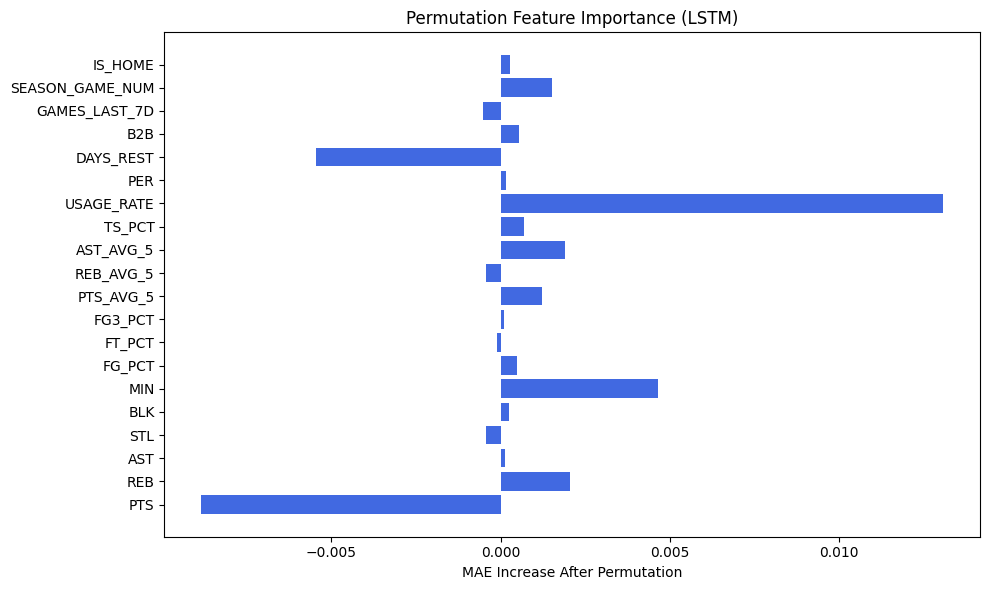

In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model # type: ignore
import matplotlib.pyplot as plt


model = load_model("../results/best_model.h5", compile=False)
X = np.load("../results/X_data.npy")          
y = np.load("../results/y_data.npy")            


X_sample = X[-5000:]               
y_sample = y[-5000:]


y_pred_base = model.predict(X_sample)
baseline_mae = mean_absolute_error(y_sample, y_pred_base)
print(f"Baseline MAE: {baseline_mae:.4f}")


feature_names = [
    'PTS', 'REB', 'AST', 'STL', 'BLK', 'MIN',
    'FG_PCT', 'FT_PCT', 'FG3_PCT',
    'PTS_AVG_5', 'REB_AVG_5', 'AST_AVG_5',
    'TS_PCT', 'USAGE_RATE', 'PER',
    'DAYS_REST', 'B2B', 'GAMES_LAST_7D',
    'SEASON_GAME_NUM', 'IS_HOME'
]


importances = []
for i, feat in enumerate(feature_names):
    X_permuted = X_sample.copy()
    for t in range(X_sample.shape[1]):
        np.random.shuffle(X_permuted[:, t, i])  

    y_pred_perm = model.predict(X_permuted)
    perm_mae = mean_absolute_error(y_sample, y_pred_perm)
    delta_mae = perm_mae - baseline_mae
    importances.append(delta_mae)
    print(f"{feat}: MAE ↑ {delta_mae:.4f}")


plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='royalblue')
plt.xlabel("MAE Increase After Permutation")
plt.title("Permutation Feature Importance (LSTM)")
plt.tight_layout()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Baseline MAE: 6.6745
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
PTS: MAE ↑ -0.0078
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
REB: MAE ↑ -0.0046
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
AST: MAE ↑ -0.0023
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
STL: MAE ↑ 0.0003
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
BLK: MAE ↑ -0.0000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MIN: MAE ↑ -0.0240
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
FG_PCT: MAE ↑ 0.0003
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
FT_PCT: MAE ↑ -0.0004
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
FG3_PCT: MAE ↑ 0.0001
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
PTS_AVG_5: MAE ↑ -0.0091
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
REB_AVG_5: MAE ↑ -0.0031
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
AST_AVG_5: MAE ↑ -0.0013
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
TS_PCT: MAE ↑ 0.0000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
USAGE_RATE: MAE ↑ 0.0144
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
PER: MAE ↑ 0.0004
157/15

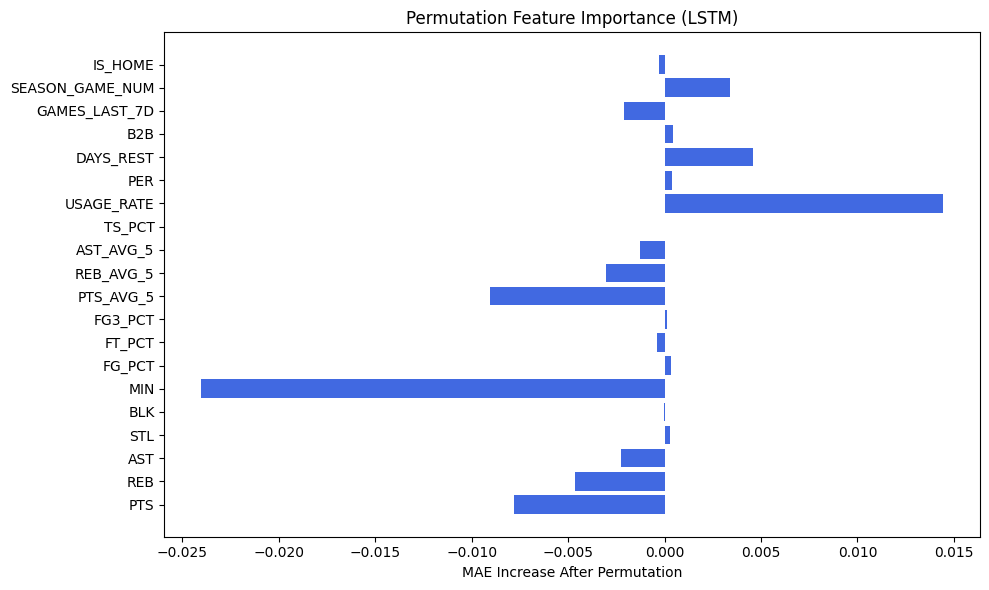

In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model # type: ignore
import matplotlib.pyplot as plt


model = load_model("../results/best_optuna_model.keras", compile=False)
X = np.load("../results/X_data.npy")          
y = np.load("../results/y_data.npy")            


X_sample = X[-5000:]               
y_sample = y[-5000:]


y_pred_base = model.predict(X_sample)
baseline_mae = mean_absolute_error(y_sample, y_pred_base)
print(f"Baseline MAE: {baseline_mae:.4f}")


feature_names = [
    'PTS', 'REB', 'AST', 'STL', 'BLK', 'MIN',
    'FG_PCT', 'FT_PCT', 'FG3_PCT',
    'PTS_AVG_5', 'REB_AVG_5', 'AST_AVG_5',
    'TS_PCT', 'USAGE_RATE', 'PER',
    'DAYS_REST', 'B2B', 'GAMES_LAST_7D',
    'SEASON_GAME_NUM', 'IS_HOME'
]


importances = []
for i, feat in enumerate(feature_names):
    X_permuted = X_sample.copy()
    for t in range(X_sample.shape[1]):
        np.random.shuffle(X_permuted[:, t, i])  

    y_pred_perm = model.predict(X_permuted)
    perm_mae = mean_absolute_error(y_sample, y_pred_perm)
    delta_mae = perm_mae - baseline_mae
    importances.append(delta_mae)
    print(f"{feat}: MAE ↑ {delta_mae:.4f}")


plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='royalblue')
plt.xlabel("MAE Increase After Permutation")
plt.title("Permutation Feature Importance (LSTM)")
plt.tight_layout()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Baseline MAE: 6.6969
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
PTS: MAE ↑ -0.0160
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
REB: MAE ↑ -0.0061
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
AST: MAE ↑ -0.0034
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
STL: MAE ↑ 0.0003
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
BLK: MAE ↑ 0.0002
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MIN: MAE ↑ -0.0079
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
FG_PCT: MAE ↑ 0.0001
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
FT_PCT: MAE ↑ -0.0001
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
FG3_PCT: MAE ↑ -0.0005
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
PTS_AVG_5: MAE ↑ 0.0126
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
REB_AVG_5: MAE ↑ 0.0008
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
AST_AVG_5: MAE ↑ 0.0001
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
TS_PCT: MAE ↑ 0.0000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
USAGE_RATE: MAE ↑ 0.0115
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
PER: MAE ↑ 0.0001
157/157 ━

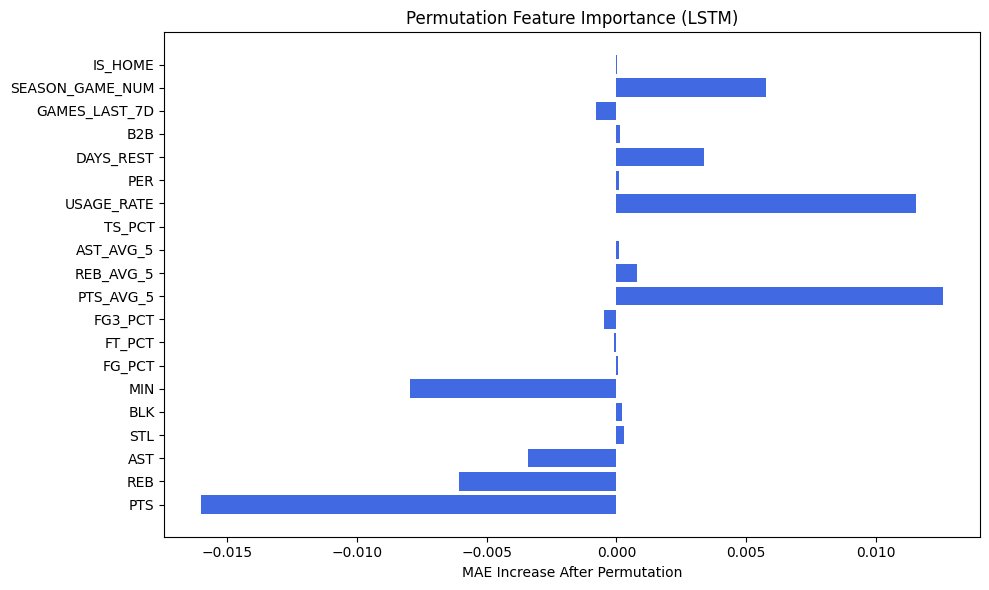

In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model # type: ignore
import matplotlib.pyplot as plt


model = load_model("../results/best_tuned_model.h5", compile=False)
X = np.load("../results/X_data.npy")          
y = np.load("../results/y_data.npy")            


X_sample = X[-5000:]               
y_sample = y[-5000:]


y_pred_base = model.predict(X_sample)
baseline_mae = mean_absolute_error(y_sample, y_pred_base)
print(f"Baseline MAE: {baseline_mae:.4f}")


feature_names = [
    'PTS', 'REB', 'AST', 'STL', 'BLK', 'MIN',
    'FG_PCT', 'FT_PCT', 'FG3_PCT',
    'PTS_AVG_5', 'REB_AVG_5', 'AST_AVG_5',
    'TS_PCT', 'USAGE_RATE', 'PER',
    'DAYS_REST', 'B2B', 'GAMES_LAST_7D',
    'SEASON_GAME_NUM', 'IS_HOME'
]


importances = []
for i, feat in enumerate(feature_names):
    X_permuted = X_sample.copy()
    for t in range(X_sample.shape[1]):
        np.random.shuffle(X_permuted[:, t, i])  

    y_pred_perm = model.predict(X_permuted)
    perm_mae = mean_absolute_error(y_sample, y_pred_perm)
    delta_mae = perm_mae - baseline_mae
    importances.append(delta_mae)
    print(f"{feat}: MAE ↑ {delta_mae:.4f}")


plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='royalblue')
plt.xlabel("MAE Increase After Permutation")
plt.title("Permutation Feature Importance (LSTM)")
plt.tight_layout()
plt.show()


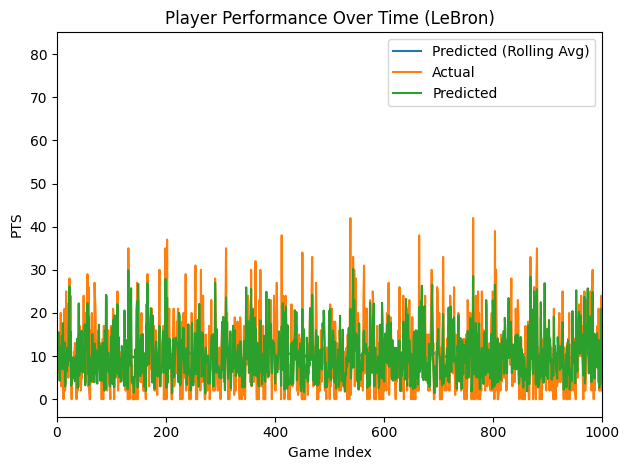

In [12]:
import pandas as pd

pd.Series(y_pred).rolling(100).mean().plot(label="Predicted (Rolling Avg)")
df_eval = pd.DataFrame({
    "player_id": 2544,  
    "actual": y_val,
    "predicted": y_pred
})
df_eval["abs_error"] = abs(df_eval["actual"] - df_eval["predicted"])


player_data = df_eval[df_eval["player_id"] ==2544 ]  
plt.plot(player_data["actual"].values, label="Actual")
plt.plot(player_data["predicted"].values, label="Predicted")
plt.title("Player Performance Over Time (LeBron)")
plt.xlabel("Game Index")
plt.xlim(0, 1000)
plt.ylabel("PTS")
plt.legend()
plt.tight_layout()
plt.show()

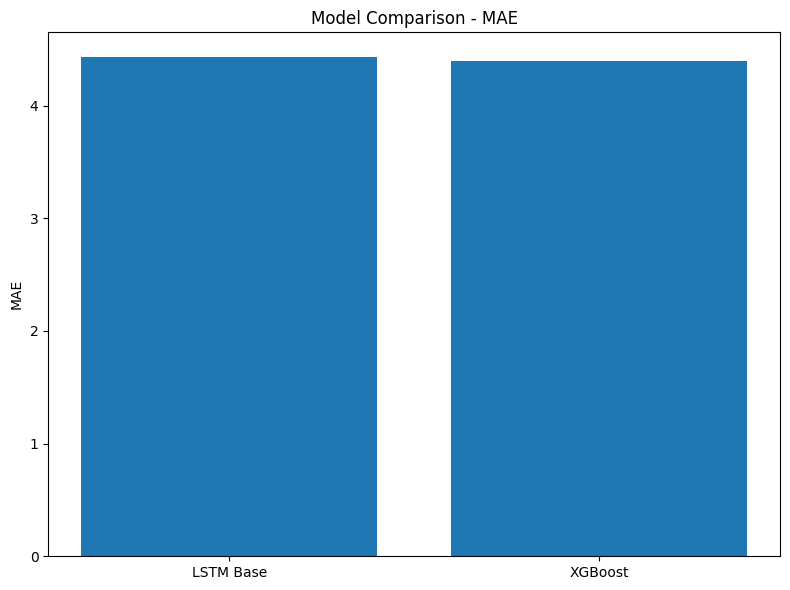

In [14]:
models = ["LSTM Base", "XGBoost"]
maes = [4.43, 4.396]  

plt.figure(figsize=(8, 6))
plt.bar(models, maes)
plt.ylabel("MAE")
plt.title("Model Comparison - MAE")
plt.tight_layout()
plt.show()